In [463]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

from datetime import datetime
import matplotlib.pyplot as plt
from math import ceil
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA

In [464]:
df = pd.read_sas('a2z_insurance.sas7bdat')
df.set_index('CustID', inplace=True)

In [465]:
df.head(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1.0,1985.0,1982.0,b'2 - High School',2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
2.0,1981.0,1995.0,b'2 - High School',677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
3.0,1991.0,1970.0,b'1 - Basic',2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
4.0,1990.0,1981.0,b'3 - BSc/MSc',1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
5.0,1986.0,1973.0,b'3 - BSc/MSc',1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


In [466]:
df.shape

(10296, 13)

In [467]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10296 entries, 1.0 to 10296.0
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   FirstPolYear   10266 non-null  float64
 1   BirthYear      10279 non-null  float64
 2   EducDeg        10279 non-null  object 
 3   MonthSal       10260 non-null  float64
 4   GeoLivArea     10295 non-null  float64
 5   Children       10275 non-null  float64
 6   CustMonVal     10296 non-null  float64
 7   ClaimsRate     10296 non-null  float64
 8   PremMotor      10262 non-null  float64
 9   PremHousehold  10296 non-null  float64
 10  PremHealth     10253 non-null  float64
 11  PremLife       10192 non-null  float64
 12  PremWork       10210 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.1+ MB


In [468]:
non_metric_features = ["EducDeg", "Children", 'GeoLivArea']
metric_features=df.columns.drop(non_metric_features).to_list()

In [469]:
df_info = pd.DataFrame(columns={"column", "NaN", "NaN %"})
for index, value in df.isna().sum().iteritems():
    df_temp = pd.DataFrame({"column" : index, "NaN" : [value], "NaN %" : round(value*100 /len(df), 2)})
    df_info = pd.concat([df_info, df_temp], ignore_index=True)
    df_info.sort_values(by="NaN", ascending=False, inplace=True)

print(df_info)

    NaN NaN %         column
0   104  1.01       PremLife
12   86  0.84       PremWork
1    43  0.42     PremHealth
2    36  0.35       MonthSal
3    34  0.33      PremMotor
4    30  0.29   FirstPolYear
5    21   0.2       Children
6    17  0.17      BirthYear
7    17  0.17        EducDeg
8     1  0.01     GeoLivArea
9     0   0.0     CustMonVal
10    0   0.0     ClaimsRate
11    0   0.0  PremHousehold


### %%%% explicar que como nenhuma coluna tem mais de 3% de Nans, não eliminamos os nans, vamos imputar

In [470]:
#Check duplicates
df.duplicated().sum()

3

In [471]:
df.drop_duplicates(inplace=True)

In [472]:
#Check duplicates
df.duplicated().sum()

0

# Fill Nans
### This data doesn't have a lot of missing values, but we will fill them with 4 different approaches and then test it when doing clusters
#### For each approach we are going to plot a range of data (using the metric with more missing values VS another metric), so that it is possible to identify the missing values ​​filled in. Since if we showed all the data, it would be impossible to see them graphically
#### All filled missing values are going to be plotted in red color

### - Using mode for both metric and non metric:

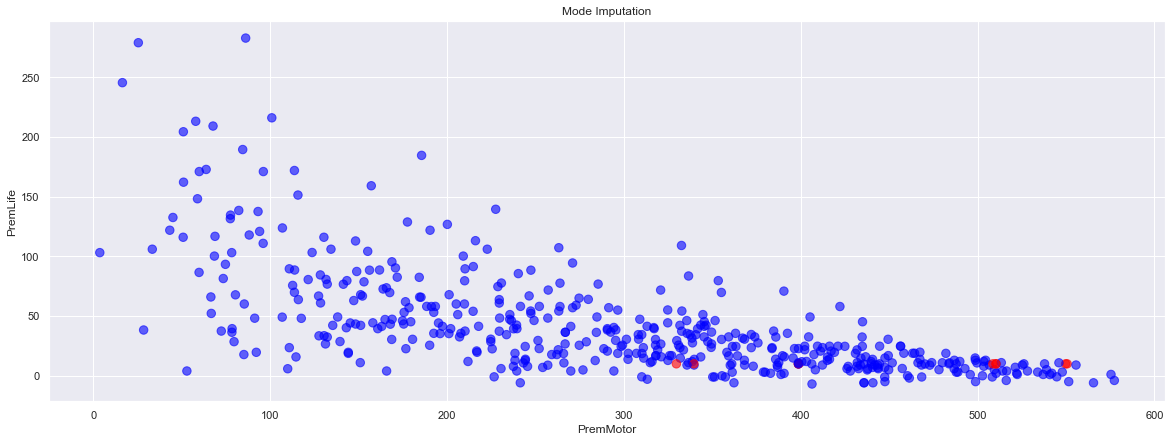

In [473]:
# Mode Imputation

df_mode = df.copy()
mode_imputer = SimpleImputer(strategy='most_frequent')
df_mode[metric_features] = mode_imputer.fit_transform(df_mode[metric_features].values)
df_mode[non_metric_features] = mode_imputer.fit_transform(df_mode[non_metric_features].values)

# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_mode[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mode Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using mean for metric and mode for non metric:

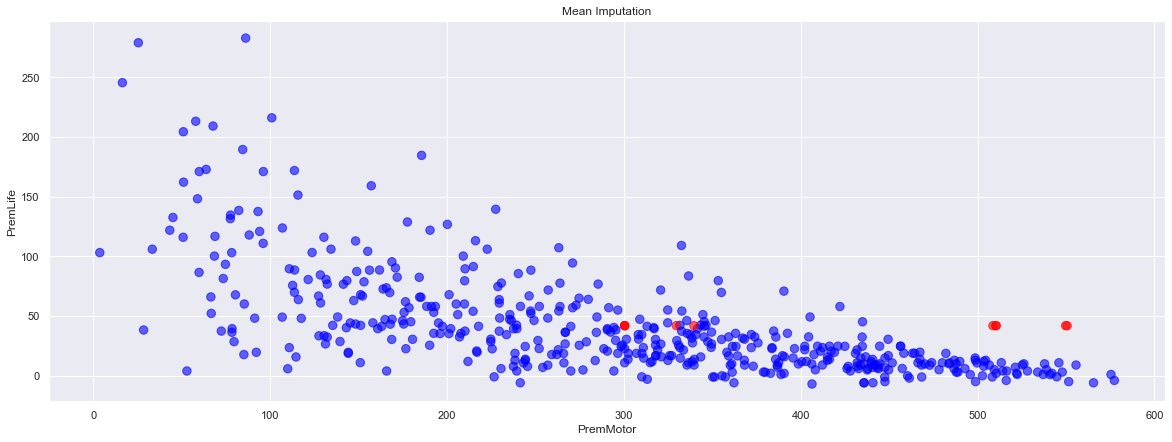

In [474]:
# Mean Imputation

df_mean = df.copy()
mean_imputer = SimpleImputer(strategy='mean')
df_mean[metric_features] = mean_imputer.fit_transform(df_mean[metric_features].values)
df_mean[non_metric_features] = mode_imputer.fit_transform(df_mean[non_metric_features].values)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_mean[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='Mean Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)



### - Using KNN Imputer for both metric and non metric:

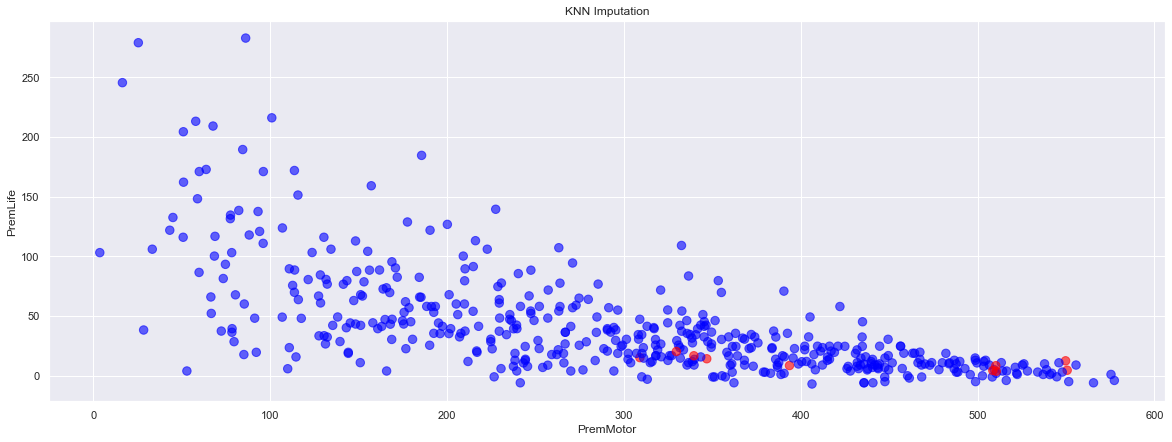

In [475]:
df_kmeans=df.copy()

le=LabelEncoder()

imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_kmeans[metric_features] = imputer.fit_transform(df_kmeans[metric_features])

dict_educdeg = {b'3 - BSc/MSc' : 3,  b'2 - High School' : 2, b'1 - Basic': 1 , b'4 - PhD': 4}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)

# df_kmeans['EducDeg']=df_kmeans['EducDeg'].astype(int)

df_kmeans[non_metric_features] = imputer.fit_transform(df_kmeans[non_metric_features])

#round new values to one of the labels
df_kmeans['EducDeg']=df_kmeans['EducDeg'].round(0)
df_kmeans['Children']=df_kmeans['Children'].round(0)
df_kmeans['GeoLivArea']=df_kmeans['GeoLivArea'].round(0)


dict_educdeg = {3 : b'3 - BSc/MSc', 2: b'2 - High School',1 :  b'1 - Basic' , 4 : b'4 - PhD'}
df_kmeans.replace({"EducDeg": dict_educdeg}, inplace=True)


# Scatter plot

fig = plt.Figure()
null_values = df['PremLife'].isnull()
fig = df_kmeans[4020:4502].plot(x='PremMotor', y='PremLife', kind='scatter', c=null_values[4020:4502], cmap='bwr', title='KNN Imputation', colorbar=False, alpha=0.6, figsize=(20,7), s=72)


### - Using linear interpolation for both metric and non metric:

<AxesSubplot:title={'center':'PremLife'}, xlabel='CustID'>

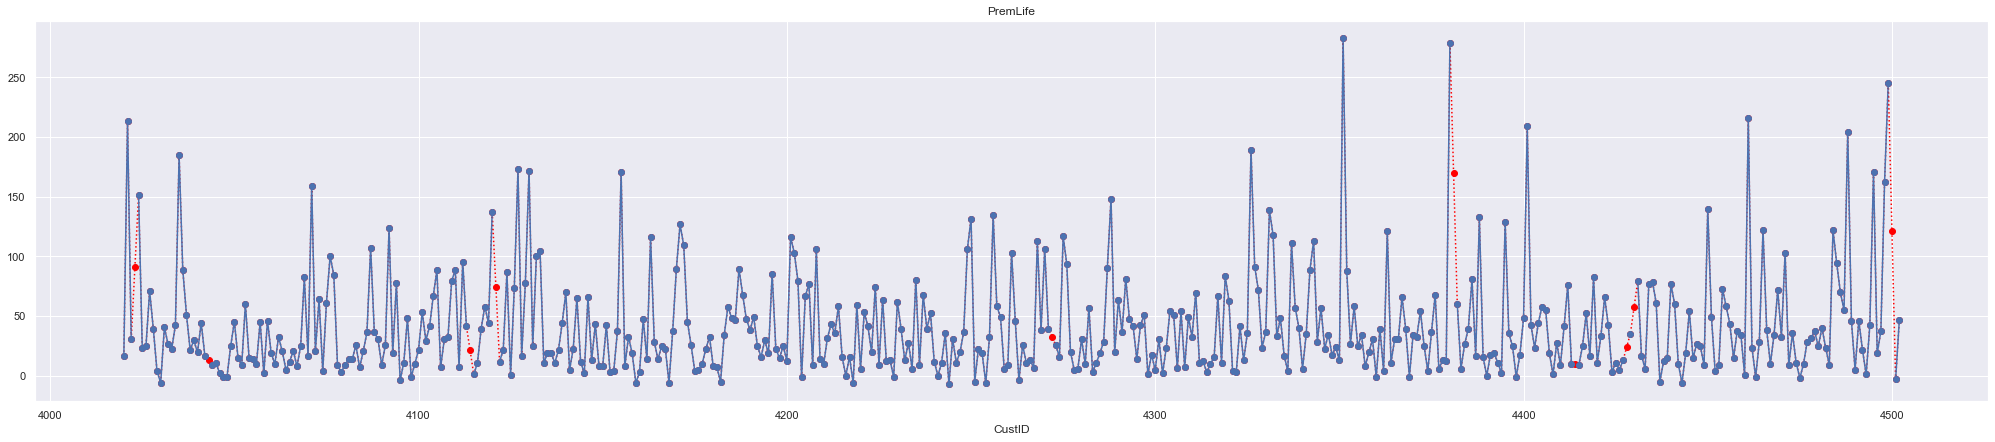

In [476]:
df_interpolation=df.copy()
# Imputing with linear interpolation
linear_interpolation = df_interpolation.interpolate(method='linear')

# Plot imputed data

linear_interpolation['PremLife'][4020:4502].plot(color='red', marker='o', linestyle='dotted')
df_interpolation['PremLife'][4020:4502].plot(title='PremLife', marker='o', figsize=(35,7))

In [477]:
df_filled=df_kmeans.copy()

In [478]:
#convert some variables to int
df_filled = df_filled.astype({'FirstPolYear': int, 'BirthYear': int, 'MonthSal': int , 'GeoLivArea': int, 'Children': int})
#convert index to int
df_filled.index = df_filled.index.astype(int)

In [479]:
df_filled.sample(5)

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
1983,1977,1952,b'3 - BSc/MSc',3713,4,0,310.17,0.47,225.93,34.45,300.39,41.34,33.45
9007,1978,1989,b'2 - High School',1572,4,1,128.47,0.84,187.59,457.30,155.03,65.90,100.02
331,1979,1986,b'2 - High School',1421,4,1,825.73,0.24,104.02,695.70,248.27,7.78,58.79
8956,1984,1963,b'2 - High School',2882,3,1,405.86,0.28,430.86,10.00,61.79,68.68,26.67
4745,1991,1988,b'3 - BSc/MSc',1445,4,1,-49.67,1.04,206.04,82.25,338.73,8.78,15.89


In [480]:
#Check if Nans were all filled
df_filled.isna().sum()

FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [481]:
# print columns with Nans
nans_index = df.isna().any(axis=1)
df[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22.0,1977.0,1958.0,b'2 - High School',NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
69.0,1983.0,1977.0,b'2 - High School',1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
139.0,1979.0,1976.0,b'2 - High School',2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
144.0,1996.0,1990.0,b'3 - BSc/MSc',NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
185.0,1993.0,1984.0,b'2 - High School',2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011.0,NaN,1947.0,b'2 - High School',3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10058.0,1983.0,1980.0,b'2 - High School',1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10143.0,1986.0,1985.0,b'3 - BSc/MSc',1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78


In [482]:
#print the same columns with Nans filled
df_filled[nans_index]

,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
CustID,,,,,,,,,,,,,
22,1977,1958,b'2 - High School',2541,3,1,111.37,0.80,407.520,111.70,100.130,24.670,30.340
69,1983,1977,b'2 - High School',1399,4,1,476.65,0.33,330.730,186.70,211.150,33.784,15.780
139,1979,1976,b'2 - High School',2538,2,1,149.59,0.69,194.260,305.60,226.598,37.340,17.670
144,1996,1990,b'3 - BSc/MSc',1721,4,1,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
185,1993,1984,b'2 - High School',2419,4,1,-62.23,1.07,264.428,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10011,1990,1947,b'2 - High School',3959,2,1,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10058,1983,1980,b'2 - High School',1569,4,1,222.60,0.55,235.600,211.15,247.602,32.340,68.790
10143,1986,1985,b'3 - BSc/MSc',1652,3,1,55.67,0.88,257.050,94.45,308.390,23.338,13.780


In [483]:
#copy to df
df=df_filled.copy()

In [484]:
#convert birth year to age
df['Age'] = 2016-df['BirthYear']
df.drop(columns='BirthYear', inplace=True)

#remove from metric_features list
metric_features.remove('BirthYear')

#add age to metric_features list
metric_features.append('Age')

In [485]:
# print of unique values to check coherence
for col in df[non_metric_features]:
    print('\033[1;3mUnique values of "' + col + '"\033[0m ')
    print(df[col].unique())
    print('\n')

Unique values of "EducDeg" 
[b'2 - High School' b'1 - Basic' b'3 - BSc/MSc' b'4 - PhD']


Unique values of "Children" 
[1 0]


Unique values of "GeoLivArea" 
[1 4 3 2]




<AxesSubplot:xlabel='GeoLivArea', ylabel='count'>

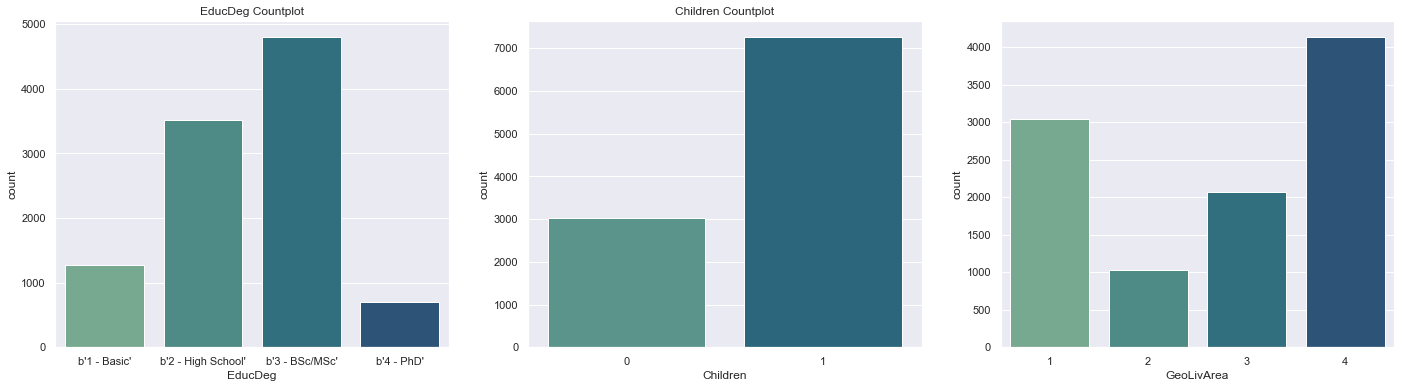

In [486]:
fig, ax = plt.subplots(1,3, figsize=(24,6))
ax[0].title.set_text('EducDeg Countplot')
ax[1].title.set_text('Children Countplot')
sns.countplot(data=df, x="EducDeg", ax=ax[0], palette='crest', order=df.EducDeg.value_counts().index.sort_values(), dodge=False)
sns.countplot(data=df, x="Children", ax=ax[1], palette='crest',  dodge=False)
sns.countplot(data=df, x="GeoLivArea", ax=ax[2], palette='crest',  dodge=False)


In [487]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
FirstPolYear,10293.0,NaN,NaN,NaN,1991.049062,510.596931,1974.0,1980.0,1986.0,1992.0,53784.0
EducDeg,10293,4,b'3 - BSc/MSc',4808,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthSal,10293.0,NaN,NaN,NaN,2506.40921,1156.183192,333.0,1706.0,2501.0,3290.0,55215.0
GeoLivArea,10293.0,NaN,NaN,NaN,2.709414,1.266241,1.0,1.0,3.0,4.0,4.0
Children,10293.0,NaN,NaN,NaN,0.706597,0.455344,0.0,0.0,1.0,1.0,1.0
CustMonVal,10293.0,NaN,NaN,NaN,177.929963,1946.091554,-165680.42,-9.44,187.03,399.86,11875.89
ClaimsRate,10293.0,NaN,NaN,NaN,0.742728,2.917385,0.0,0.39,0.72,0.98,256.2
PremMotor,10293.0,NaN,NaN,NaN,300.702459,211.67798,-4.11,191.26,299.28,408.3,11604.42
PremHousehold,10293.0,NaN,NaN,NaN,210.419863,352.635041,-75.0,49.45,132.8,290.05,25048.8
PremHealth,10293.0,NaN,NaN,NaN,171.596339,295.845039,-2.11,111.91,162.92,219.04,28272.0


### Analysis before outliers

In [488]:
def box_plot_all_vars(data):
    # All Numeric Variables' Box Plots in one figure
    sns.set()

    # Prepare figure. Create individual axes where each box plot will be placed
    fig, axes = plt.subplots(4, ceil(len(metric_features) / 4), figsize=(25, 20))

    # Plot data
    # Iterate across axes objects and associate each box plot (hint: use the ax argument):
    for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
        bxplot = sns.boxplot(x=data[feat], ax=ax, color='chartreuse', fliersize=8)
        bxplot.set_xlabel(fontsize=16, xlabel=feat)

    
        
    # Layout
    # Add a centered title to the figure:
    title = "Numeric Variables' Box Plots"

    plt.suptitle(title, size=30)

    plt.show()

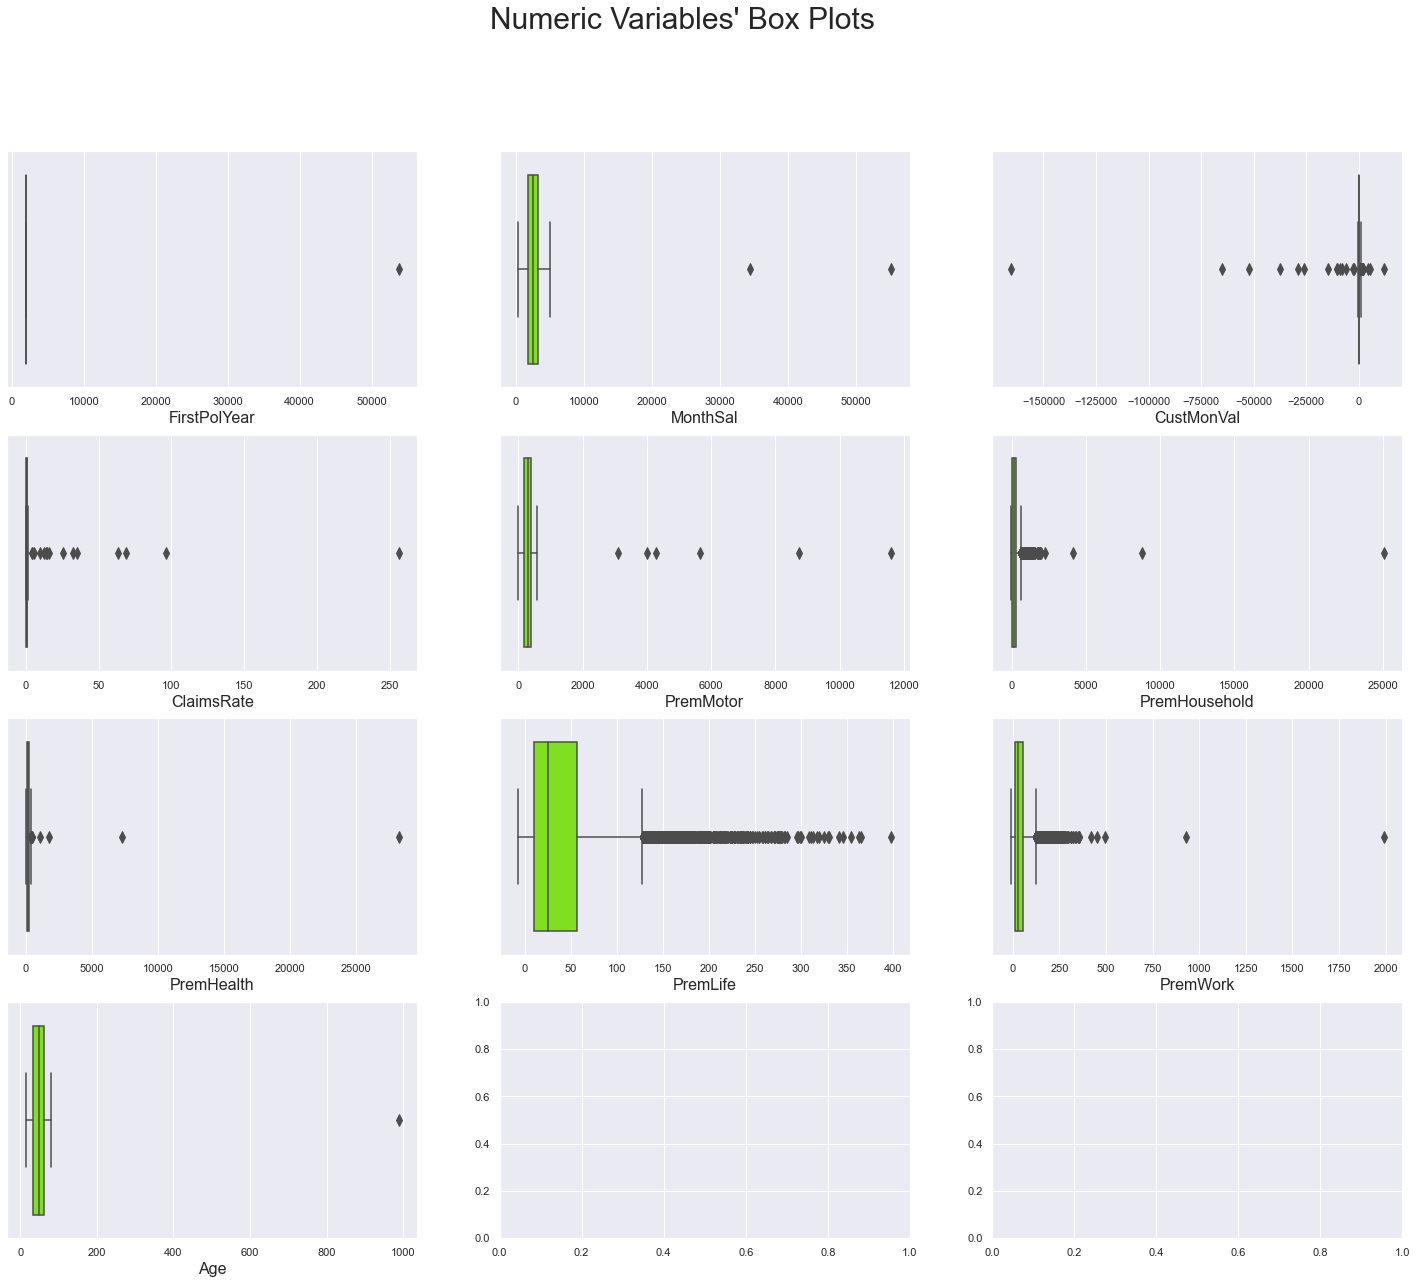

In [489]:
box_plot_all_vars(df)

In [490]:
##Following quartiles
filters1 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=5500)
    &
    (df['CustMonVal']>=-3000)
    &
    (df['CustMonVal']<=3000)
    &
    (df['ClaimsRate']<=6)
    &
    (df['PremMotor']<=700)
    &
    (df['PremHousehold']<=1500)
    &
    (df['PremHealth']<=760)
    &
    (df['PremLife']<=150)
    &
    (df['Age']<=85)
)

df_1 = df[filters1]
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9553


In [491]:
# df_3['FirstPolYear'].unique()

In [492]:
##IQR method
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive='both'))

filters2 = pd.Series(np.all(filters2, 0))
df_2=df.copy()
df_2['filters2'] = filters2.to_list()
df_2=df_2[df_2['filters2']!=False]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.8541


In [493]:
##Combining the 2 above
df_3 = df.copy()
df_3['filters1'] = filters1.to_list()
df_3['filters2'] = filters2
df_3 = df_3[(df_3['filters1']==True) | (df_3['filters2']==True)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9947


In [494]:
##Removing more critical data points
filters3 = (
    (df['FirstPolYear']<=2016)
    &
    (df['MonthSal']<=30000)
    &
    (df['CustMonVal']>=-75000)
    &
    (df['ClaimsRate']<=100)
    &
    (df['PremMotor']<=6000)
    &
    (df['PremHousehold']<=5000)
    &
    (df['PremHealth']<=5000)
    &
    (df['PremLife']<=398)
    &
    (df['Age']<=85)
)

df_4 = df[filters3]
print('Percentage of data kept after removing outliers:', np.round(df_4.shape[0] / df.shape[0], 4))

Percentage of data kept after removing outliers: 0.9988


In [495]:
## print para comparar os dois metodos de outliers, e colocar que se escolheu so usar o manual
df_3.drop(columns=['filters1','filters2'], inplace=True)
print('Data shape before outliers removal:')
print(df.shape)
print('Data shape after outliers removal:')
print('df_1: ', df_1.shape)
print('df_2: ', df_2.shape)
print('df_3: ', df_3.shape)
print('df_4: ', df_4.shape)

Data shape before outliers removal:
(10293, 13)
Data shape after outliers removal:
df_1:  (9833, 13)
df_2:  (8791, 14)
df_3:  (10238, 13)
df_4:  (10281, 13)


In [496]:
df=df_4.copy()

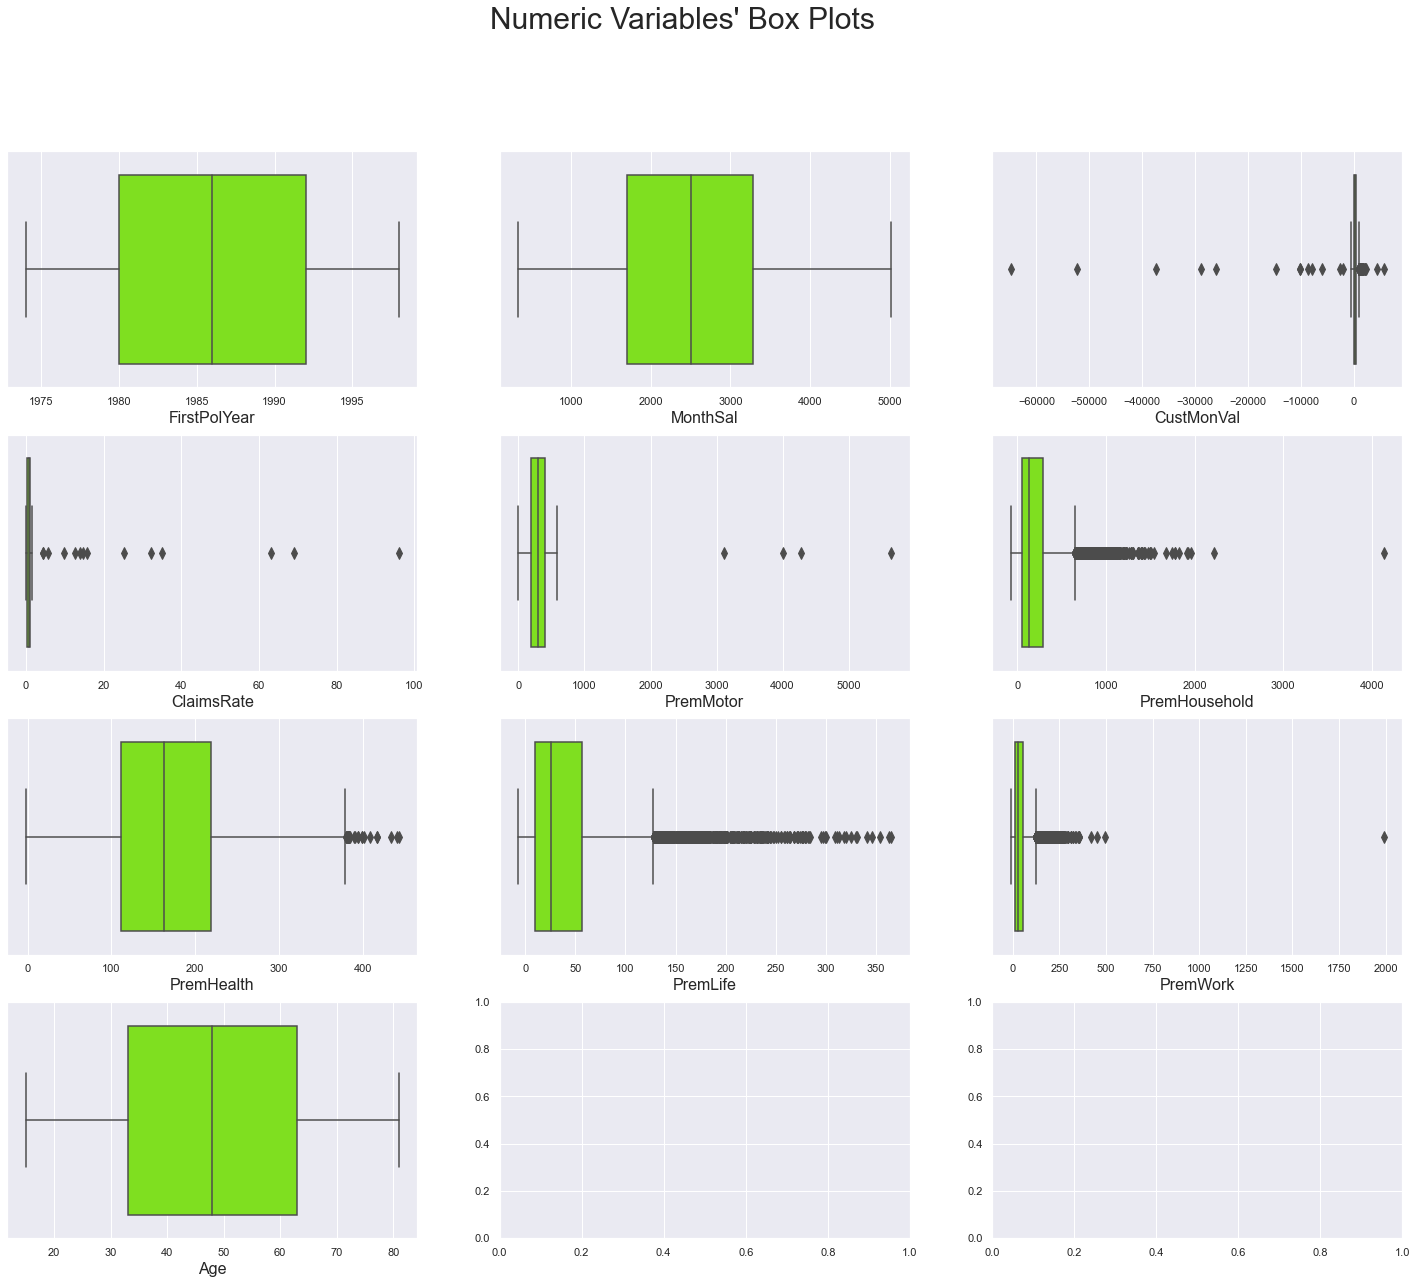

In [497]:
box_plot_all_vars(df)

In [498]:
df['FirstPolYear'].unique()

array([1985, 1981, 1991, 1990, 1986, 1979, 1988, 1976, 1983, 1977, 1998,
       1974, 1978, 1995, 1980, 1984, 1989, 1987, 1982, 1994, 1993, 1992,
       1997, 1996, 1975])

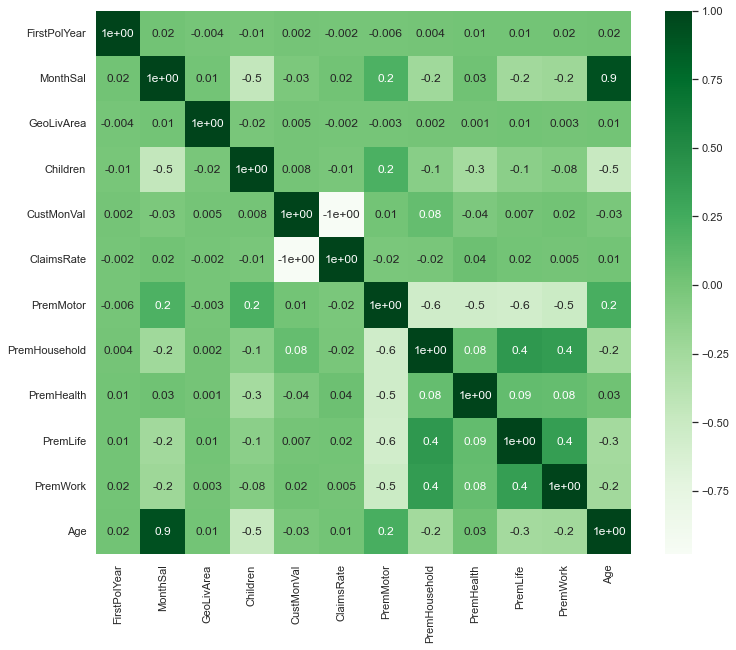

In [499]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Greens, fmt='.1')
    plt.show()
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

#droppar monthsal?

In [500]:
##Drop columns with very high correlations
df.drop(columns=['MonthSal','CustMonVal'], inplace=True)
metric_features.remove('MonthSal')
metric_features.remove('CustMonVal')

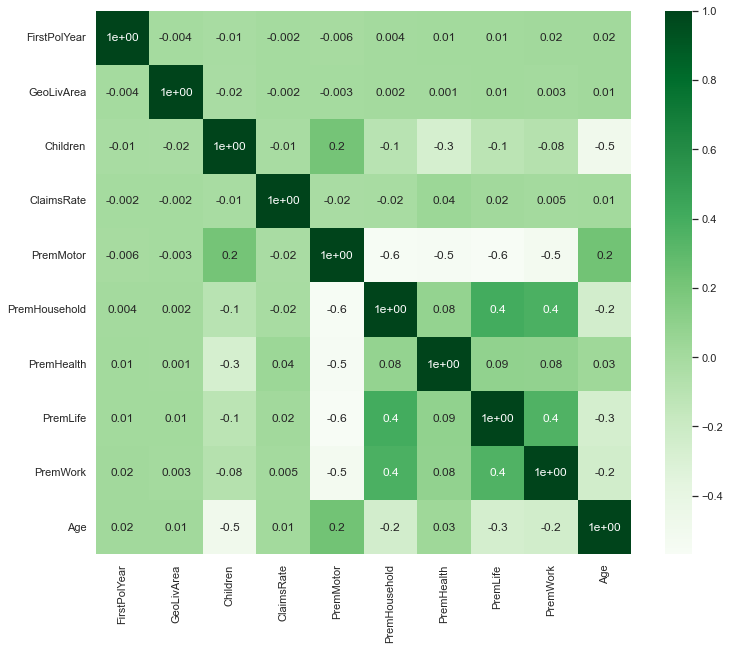

In [501]:
cor_pearson = df.corr()
cor_heatmap(cor_pearson)

<AxesSubplot:xlabel='PremLife', ylabel='PremMotor'>

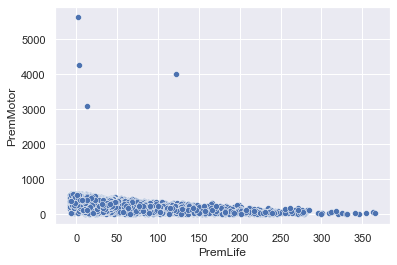

In [502]:
sns.scatterplot(x='PremLife', y='PremMotor', data=df)

In [503]:
df[metric_features].sample(5)

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age
CustID,,,,,,,,
8907,1984,0.83,33.23,966.30,87.35,235.60,31.45,22
3993,1996,1.10,333.95,240.05,124.69,63.79,14.56,71
7457,1977,0.85,409.30,84.45,151.25,5.78,6.78,35
9270,1982,0.40,198.48,511.20,194.26,89.46,14.56,65
1837,1976,0.88,437.86,79.45,142.47,4.89,-0.11,36


### MinMaxScaler

In [504]:
df_minmax=df.copy()
#normalize with minmaxscaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df_minmax[metric_features])
df_minmax[metric_features] = scaled_features

df_minmax.describe().T



,count,mean,std,min,25%,50%,75%,max
FirstPolYear,10281.0,0.500665,0.275198,0.0,0.250000,0.500000,0.750000,1.0
GeoLivArea,10281.0,2.708589,1.266407,1.0,1.000000,3.000000,4.000000,4.0
Children,10281.0,0.706838,0.455234,0.0,0.000000,1.000000,1.000000,1.0
ClaimsRate,10281.0,0.007478,0.015353,0.0,0.004063,0.007500,0.010208,1.0
PremMotor,10281.0,0.053610,0.028244,0.0,0.034581,0.053701,0.072998,1.0
PremHousehold,10281.0,0.067084,0.056913,0.0,0.029591,0.049409,0.086799,1.0
PremHealth,10281.0,0.382175,0.166645,0.0,0.256242,0.370632,0.497000,1.0
PremLife,10281.0,0.130504,0.126868,0.0,0.045381,0.087189,0.171987,1.0
PremWork,10281.0,0.026502,0.025271,0.0,0.011331,0.018828,0.034048,1.0
Age,10281.0,0.498547,0.263417,0.0,0.272727,0.500000,0.727273,1.0


### StandartScaler

In [505]:
df_st_scaler=df.copy()
#normalize with standart scaler
from sklearn.preprocessing import StandardScaler
standart_scaler = StandardScaler()
standart_scaler_features = standart_scaler.fit_transform(df_st_scaler[metric_features])
df_st_scaler[metric_features] = standart_scaler_features

df_st_scaler.describe().T

,count,mean,std,min,25%,50%,75%,max
FirstPolYear,10281.0,-2.737945e-15,1.000049,-1.819374,-0.910895,-0.002415,0.906064,1.814544
GeoLivArea,10281.0,2.708589e+00,1.266407,1.000000,1.000000,3.000000,4.000000,4.000000
Children,10281.0,7.068379e-01,0.455234,0.000000,0.000000,1.000000,1.000000,1.000000
ClaimsRate,10281.0,-6.509507e-17,1.000049,-0.487130,-0.222506,0.001407,0.177823,64.651181
PremMotor,10281.0,-3.691025e-17,1.000049,-1.898182,-0.673764,0.003217,0.686465,33.508930
PremHousehold,10281.0,-9.459735e-18,1.000049,-1.178775,-0.658819,-0.310579,0.346417,16.392799
PremHealth,10281.0,1.159250e-17,1.000049,-2.293454,-0.755732,-0.069273,0.689069,3.707601
PremLife,10281.0,1.160869e-16,1.000049,-1.028707,-0.670985,-0.341431,0.326995,6.853892
PremWork,10281.0,5.882098e-17,1.000049,-1.048759,-0.600362,-0.303672,0.298608,38.523717
Age,10281.0,-2.870317e-17,1.000049,-1.892707,-0.857312,0.005517,0.868346,1.903741


In [507]:
## Choosing standart scaler
df=df_st_scaler.copy()

In [508]:
df[non_metric_features]

,EducDeg,Children,GeoLivArea
CustID,,,
1,b'2 - High School',1,1
2,b'2 - High School',1,4
3,b'1 - Basic',0,3
4,b'3 - BSc/MSc',1,4
5,b'3 - BSc/MSc',1,4
...,...,...,...
10292,b'4 - PhD',0,2
10293,b'1 - Basic',0,3
10294,b'3 - BSc/MSc',1,1


In [509]:
##ONE HOT ENCODING
df_ohc = df[non_metric_features].copy()

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc)
ohc_feat_names = ohc.get_feature_names_out()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)
ohc_df.drop(['Children_0'],axis=1, inplace=True)
ohc_df



,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4
CustID,,,,,,,,,
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...
10292,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10294,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [510]:
df_scaled=df.merge(ohc_df, on = 'CustID')
df_scaled.drop(['Children', 'EducDeg', 'GeoLivArea'],axis=1, inplace=True)
df_scaled

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4
CustID,,,,,,,,,,,,,,,,,
1,-0.153829,-0.222506,0.483095,-0.533477,-0.291124,0.115199,-0.477334,-0.799791,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,-0.759482,0.272817,-1.386969,0.873477,-0.691267,3.238545,1.287772,-1.547576,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.754651,-0.297144,-0.580445,0.072547,-0.584859,0.948402,1.147141,-0.109527,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.603238,0.184609,-0.728789,-0.684305,1.931574,-0.131966,-0.250861,-0.742269,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
5,-0.002415,0.123541,0.249768,-0.665712,0.197489,-0.482699,0.008446,-0.282093,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10292,-0.305242,0.164253,0.595215,-0.658819,0.079078,-0.673315,-0.519069,1.098434,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10293,-1.365135,-0.487130,-1.035254,3.461980,-0.333067,-0.607446,1.267992,0.925868,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
10294,1.208891,-0.344640,0.657197,-0.310579,-0.346554,-0.612106,-0.714686,-0.454659,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [511]:
##PCA
df_pca = df_scaled.copy()


pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat  



array([[ 5.11531924e-01, -6.40468824e-01,  1.42954599e-01, ...,
        -2.74282725e-01, -3.76880507e-01,  4.55081356e-02],
       [-3.36178718e+00, -1.69744917e+00,  8.85422938e-01, ...,
        -8.67808418e-01, -1.56101548e+00,  2.40590022e-04],
       [-1.13995323e+00, -6.87080314e-01, -8.28425280e-01, ...,
         3.71708942e-01, -7.55710995e-01, -1.89819644e-01],
       ...,
       [ 1.02745203e+00, -3.95412332e-01, -1.17231010e+00, ...,
        -1.82230160e-01,  2.88329280e-01, -4.91295921e-02],
       [-1.42423684e+00, -1.16226662e-01,  6.75248034e-01, ...,
         9.35139192e-01, -4.96168392e-01,  9.24829173e-02],
       [ 1.05263209e+00, -5.72370690e-01, -5.81966989e-01, ...,
         7.32677991e-02,  2.27076188e-01, -3.79134088e-02]])

In [512]:
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,2.648430,0.000000,0.331022,0.331022
2,1.176750,-1.471680,0.147079,0.478101
3,1.003370,-0.173380,0.125409,0.603510
4,0.987670,-0.015701,0.123447,0.726957
5,0.768256,-0.219413,0.096023,0.822980
6,0.650709,-0.117547,0.081331,0.904310
7,0.596537,-0.054173,0.074560,0.978870
8,0.169055,-0.427481,0.021130,1.000000


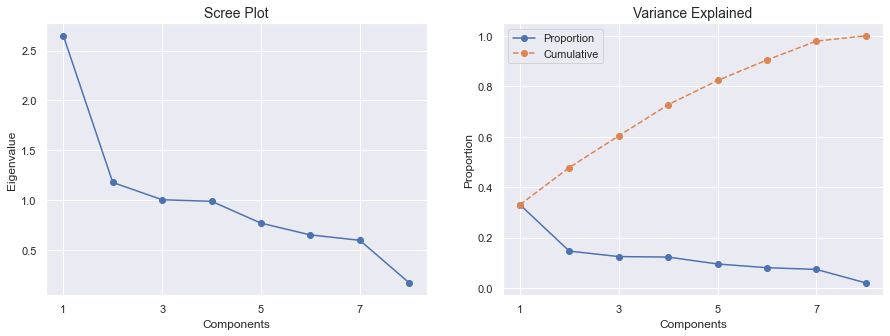

In [513]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")


ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [514]:
#3 ou 4 componentes
pca = PCA(n_components=3)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2
CustID,,,
1,0.511532,-0.640469,0.142955
2,-3.361787,-1.697449,0.885423
3,-1.139953,-0.687080,-0.828425
4,-0.619032,1.549891,-0.393290
5,0.514203,0.159757,0.089934
...,...,...,...
10292,1.406967,0.739114,0.276529
10293,-2.004458,-0.462086,0.854417
10294,1.027452,-0.395412,-1.172310


In [515]:
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4,PC0,PC1,PC2
CustID,,,,,,,,,,,,,,,,,,,,
1,-0.153829,-0.222506,0.483095,-0.533477,-0.291124,0.115199,-0.477334,-0.799791,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.511532,-0.640469,0.142955
2,-0.759482,0.272817,-1.386969,0.873477,-0.691267,3.238545,1.287772,-1.547576,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,-3.361787,-1.697449,0.885423
3,0.754651,-0.297144,-0.580445,0.072547,-0.584859,0.948402,1.147141,-0.109527,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.139953,-0.687080,-0.828425
4,0.603238,0.184609,-0.728789,-0.684305,1.931574,-0.131966,-0.250861,-0.742269,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.619032,1.549891,-0.393290
5,-0.002415,0.123541,0.249768,-0.665712,0.197489,-0.482699,0.008446,-0.282093,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.514203,0.159757,0.089934


In [516]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color
    


# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)



,PC0,PC1,PC2
FirstPolYear,-0.013462,0.074508,-0.908942
ClaimsRate,-0.021862,0.260783,0.410499
PremMotor,0.896254,-0.292475,0.005062
PremHousehold,-0.713948,-0.190298,-0.019085
PremHealth,-0.400786,0.810450,-0.000718
PremLife,-0.720647,-0.156331,0.001937
PremWork,-0.682312,-0.175116,-0.025554
Age,0.434752,0.519026,-0.086834


In [517]:
#Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3)
hc_labels = hclust.fit_predict(df[metric_features])
hc_labels

array([1, 2, 0, ..., 1, 0, 1], dtype=int64)

In [518]:
# Characterizing the clusters
df_concat = pd.concat((df_pca, pd.Series(hc_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4,PC0,PC1,PC2
labels,,,,,,,,,,,,,,,,,,,,
0.0,-0.005718,0.004065,-0.008354,-0.010797,0.008908,0.000998,0.012492,-0.006234,0.121788,0.349816,0.459296,0.069100,0.710214,0.296696,0.100410,0.197797,0.405096,-0.009410,0.006243,0.007235
1.0,0.005271,0.003087,0.009853,0.005308,-0.011463,-0.011908,-0.025018,0.014024,0.124365,0.336871,0.470697,0.068066,0.704199,0.293724,0.103369,0.202353,0.400554,0.025346,0.001417,-0.004161
2.0,-0.000552,-0.024575,-0.001125,0.015427,0.008812,0.033531,0.035817,-0.026386,0.127692,0.326154,0.483846,0.062308,0.703846,0.305385,0.093077,0.203846,0.397692,-0.046139,-0.025006,-0.008438


In [519]:
# Computing SST
X = df[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [452]:
df_pca.columns

Index(['FirstPolYear', 'ClaimsRate', 'PremMotor', 'PremHousehold',
       'PremHealth', 'PremLife', 'PremWork', 'Age', 'EducDeg_b'1 - Basic'',
       'EducDeg_b'2 - High School'', 'EducDeg_b'3 - BSc/MSc'',
       'EducDeg_b'4 - PhD'', 'Children_1', 'GeoLivArea_1', 'GeoLivArea_2',
       'GeoLivArea_3', 'GeoLivArea_4', 'PC0', 'PC1', 'PC2'],
      dtype='object')

In [520]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df) #get cluster labels
        
        
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

In [521]:
df_aa=df_pca[metric_features]
df_aa

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age
CustID,,,,,,,,
1,-0.153829,-0.222506,0.483095,-0.533477,-0.291124,0.115199,-0.477334,-0.799791
2,-0.759482,0.272817,-1.386969,0.873477,-0.691267,3.238545,1.287772,-1.547576
3,0.754651,-0.297144,-0.580445,0.072547,-0.584859,0.948402,1.147141,-0.109527
4,0.603238,0.184609,-0.728789,-0.684305,1.931574,-0.131966,-0.250861,-0.742269
5,-0.002415,0.123541,0.249768,-0.665712,0.197489,-0.482699,0.008446,-0.282093
...,...,...,...,...,...,...,...,...
10292,-0.305242,0.164253,0.595215,-0.658819,0.079078,-0.673315,-0.519069,1.098434
10293,-1.365135,-0.487130,-1.035254,3.461980,-0.333067,-0.607446,1.267992,0.925868
10294,1.208891,-0.344640,0.657197,-0.310579,-0.346554,-0.612106,-0.714686,-0.454659


In [455]:
# df_aa.describe().T

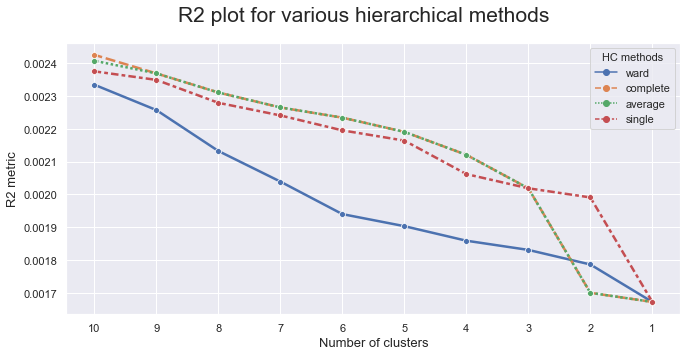

In [522]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

In [523]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[metric_features])

array([6337, 9579, 7559, ...,    2,    1,    0], dtype=int64)

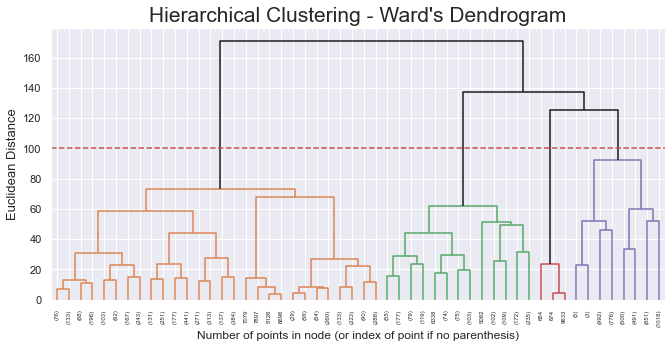

In [524]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

In [525]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
hc4_labels = hc4lust.fit_predict(df[metric_features])

In [526]:
# Characterizing the 4 clusters
df_concat = pd.concat((df_pca, pd.Series(hc4_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,FirstPolYear,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork,Age,EducDeg_b'1 - Basic',EducDeg_b'2 - High School',EducDeg_b'3 - BSc/MSc',EducDeg_b'4 - PhD',Children_1,GeoLivArea_1,GeoLivArea_2,GeoLivArea_3,GeoLivArea_4,PC0,PC1,PC2
labels,,,,,,,,,,,,,,,,,,,,
0.0,-0.005851,0.004039,-0.008556,-0.010562,0.008780,0.001351,0.012740,-0.006154,0.121867,0.349611,0.459594,0.068928,0.710242,0.296889,0.100259,0.197926,0.404927,-0.009831,0.006093,0.007327
1.0,0.005271,0.003087,0.009853,0.005308,-0.011463,-0.011908,-0.025018,0.014024,0.124365,0.336871,0.470697,0.068066,0.704199,0.293724,0.103369,0.202353,0.400554,0.025346,0.001417,-0.004161
2.0,-0.000552,-0.024575,-0.001125,0.015427,0.008812,0.033531,0.035817,-0.026386,0.127692,0.326154,0.483846,0.062308,0.703846,0.305385,0.093077,0.203846,0.397692,-0.046139,-0.025006,-0.008438
3.0,0.199469,0.044380,0.304083,-0.372484,0.205985,-0.543061,-0.370328,-0.128701,0.000000,0.666667,0.000000,0.333333,0.666667,0.000000,0.333333,0.000000,0.666667,0.639296,0.238097,-0.134781


##### GeoLivArea categórica!!!!
##### -print dos uniques para ver que está coerente
##### -ver features, se se pode fazer mais alguma coisa
##### -imputar NAs de maneiras diferentes para se comparar (criar dfs diferentes para depois se testar nos clusterings)
##### -fazer gráficos de distribuição dos dados
##### -correlações?? para depois colocar scatters??
##### -normalizar - minmax
##### -onehot encoding
##### -PCA( não sei se será útil devido às baixas correlaçoes)
##### -clustering
